In [1]:
import numpy as np
import matplotlib.pyplot as plt

from utils import *

import torchvision.models as models

import logging
from transformers import AutoFeatureExtractor, AutoModelForImageClassification

logging.basicConfig(level=logging.ERROR)

/Users/ktnorton/anaconda3/envs/w281/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = "../Data_Cropped_and_Resized"

### Feature Extraction

In [3]:
resnet101 = models.resnet101(pretrained=True)

/Users/ktnorton/anaconda3/envs/w281/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ktnorton/anaconda3/envs/w281/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
extractor = AutoFeatureExtractor.from_pretrained("DunnBC22/vit-base-patch16-224-in21k_covid_19_ct_scans")
model = AutoModelForImageClassification.from_pretrained("DunnBC22/vit-base-patch16-224-in21k_covid_19_ct_scans")
model.eval()

/Users/ktnorton/anaconda3/envs/w281/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [5]:
train_path = f"{data_dir}/train"

train_imgs, train_sobel_edges, train_labels = extract_features(train_path, detect_edges_sobel)
_, train_threshold_edges, _ = extract_features(train_path, threshold_image)
_, train_canny_edges, _ = extract_features(train_path, detect_canny_edges)
_, train_soft_tissue, _ = extract_features(train_path, get_soft_tissue)

# _, train_resnet_feat, _ = extract_features(train_path, get_resnet_features, {"model": resnet101})
_, train_transformer_feat, _ = extract_features(train_path, transformer_feature_vector, {"model": model, "extractor": extractor})

In [6]:
valid_path = f"{data_dir}/valid"

valid_imgs, valid_sobel_edges, valid_labels = extract_features(valid_path, detect_edges_sobel)
_, valid_threshold_edges, _ = extract_features(valid_path, threshold_image)
_, valid_canny_edges, _ = extract_features(valid_path, detect_canny_edges)
_, valid_soft_tissue, _ = extract_features(valid_path, get_soft_tissue)

# _, valid_resnet_feat, _ = extract_features(valid_path, get_resnet_features, {"model": resnet101})
_, valid_transformer_feat, _ = extract_features(valid_path, transformer_feature_vector, {"model": model, "extractor": extractor})

In [10]:
# dimensionality reduction

### individual edge features
input_features = np.array([[img.flatten() for img in train_sobel_edges],
                            [img.flatten() for img in train_soft_tissue],
                            [img.flatten() for img in train_threshold_edges],
                            [img.flatten() for img in train_canny_edges]])

X_train_sobel_pca, X_train_hounsfield_pca, X_train_thresh_pca, X_train_canny_pca = get_PCA(input_features, n_components=2)[-1]
X_train_sobel_tsne, X_train_hounsfield_tsne, X_train_thresh_tsne, X_train_canny_tsne = get_tsne(input_features, n_components=2)

input_features = np.array([[img.flatten() for img in valid_sobel_edges],
                            [img.flatten() for img in valid_soft_tissue],
                            [img.flatten() for img in valid_threshold_edges],
                            [img.flatten() for img in valid_canny_edges]])
X_val_sobel_pca, X_val_hounsfield_pca, X_val_thresh_pca, X_val_canny_pca = get_PCA(input_features, n_components=2)[-1]
X_val_sobel_tsne, X_val_hounsfield_tsne, X_val_thresh_tsne, X_val_canny_tsne = get_tsne(input_features, n_components=2)

### combined features
# combined_train_features = np.array([[np.array([x, y]).flatten() for x, y in zip(train_soft_tissue, train_transformer_feat)]])
# X_train_combined_pca = get_PCA(combined_train_features, n_components=2)[-1][0]
# X_train_combined_tsne = get_tsne(combined_train_features, n_components=2)[0]

# combined_val_features = np.array([[np.array([x, y]).flatten() for x, y in zip(valid_soft_tissue, valid_transformer_feat)]])
# X_val_combined_pca = get_PCA(combined_val_features, n_components=2)[-1][0]
# X_val_combined_tsne = get_tsne(combined_val_features, n_components=2)[0]

##### Sobel edges features

In [11]:
X_train = np.array([img.flatten() for img in train_sobel_edges])
X_val = np.array([img.flatten() for img in valid_sobel_edges])

Decision Tree
Accuracy: 0.4861111111111111


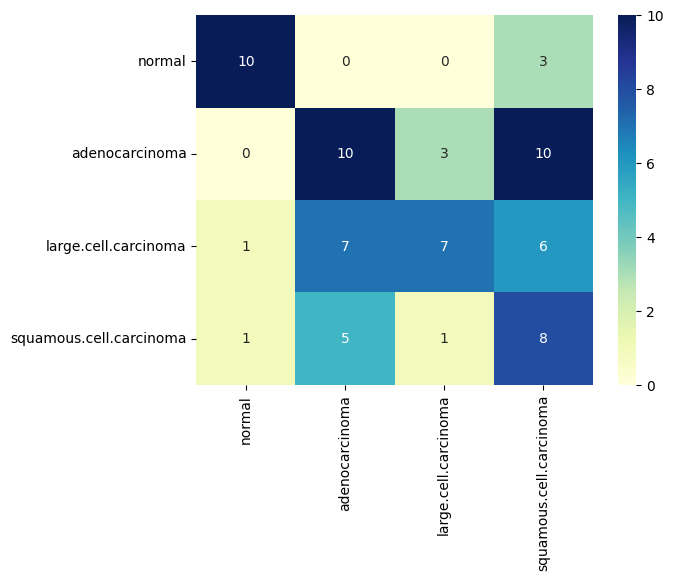

In [12]:
print("Decision Tree")
sobel_preds = classify_decision_tree(X_train, train_labels, X_val, valid_labels)
plot_confusion_matrix(valid_labels, sobel_preds)

SVM
Accuracy: 0.6666666666666666


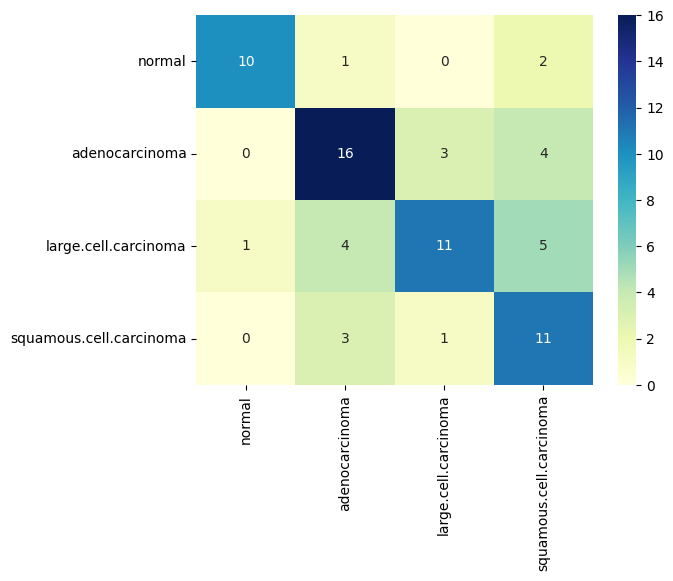

In [13]:
print("SVM")
sobel_preds = linear_svm(X_train, train_labels, X_val, valid_labels)
plot_confusion_matrix(valid_labels, sobel_preds)

RF
Accuracy: 0.5277777777777778


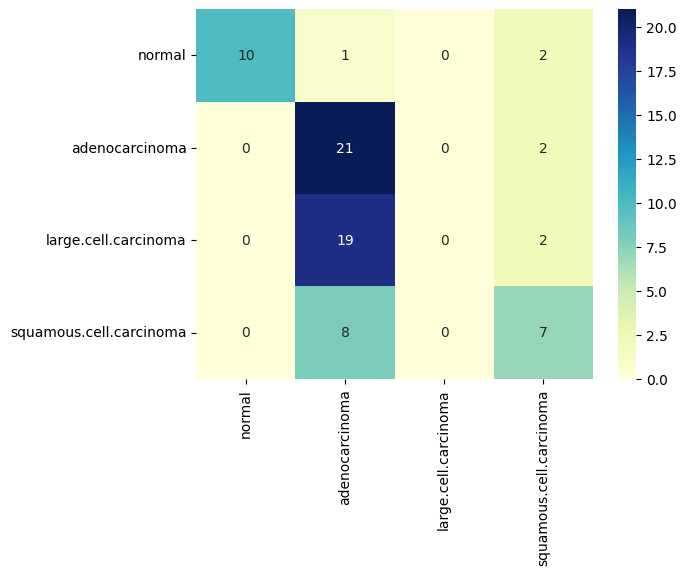

In [14]:
print("RF")
sobel_preds = classify_rf(X_train, train_labels, X_val, valid_labels)
plot_confusion_matrix(valid_labels, sobel_preds)

##### Simple threshold features

In [15]:
X_train = np.array([img.flatten() for img in train_threshold_edges])
X_val = np.array([img.flatten() for img in valid_threshold_edges])

Decision Tree
Accuracy: 0.4583333333333333


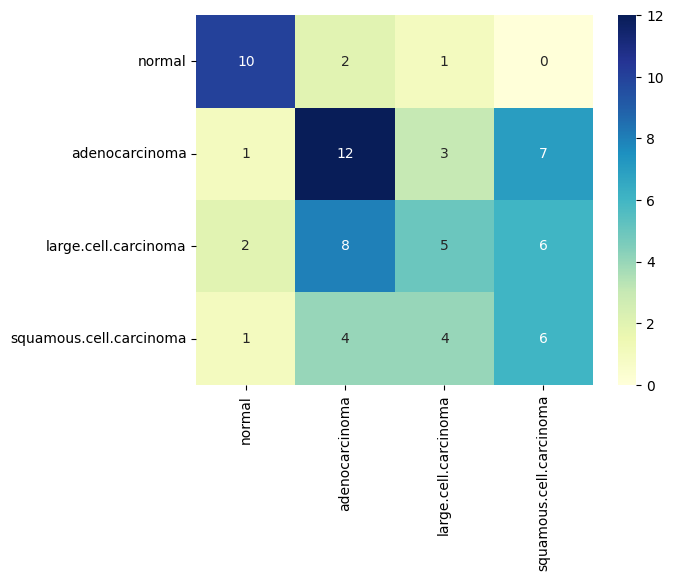

In [16]:
print("Decision Tree")
thresh_preds = classify_decision_tree(X_train, train_labels, X_val, valid_labels)
plot_confusion_matrix(valid_labels, thresh_preds)

SVM
Accuracy: 0.6944444444444444


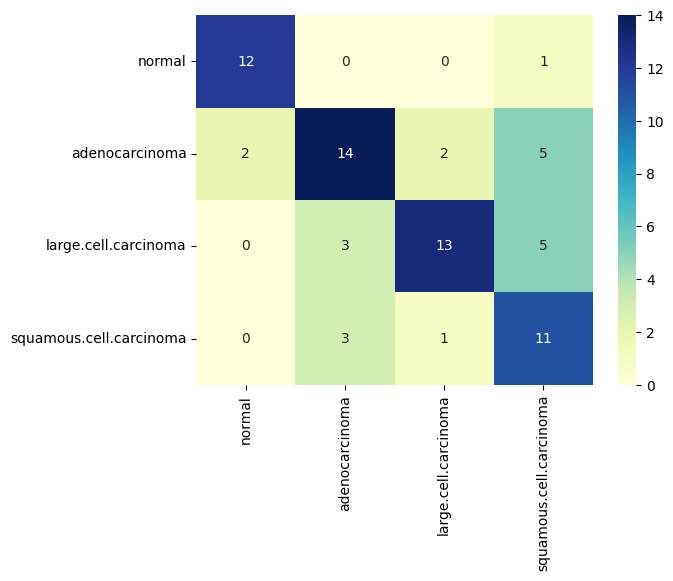

In [17]:
print("SVM")
thresh_preds = linear_svm(X_train, train_labels, X_val, valid_labels)
plot_confusion_matrix(valid_labels, thresh_preds)

RF
Accuracy: 0.625


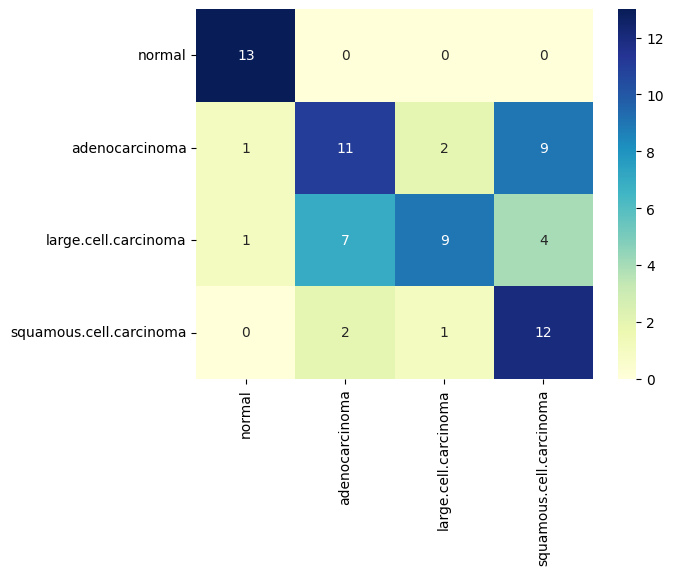

In [18]:
print("RF")
thresh_preds = classify_rf(X_train, train_labels, X_val, valid_labels)
plot_confusion_matrix(valid_labels, thresh_preds)

##### Canny edges

In [19]:
X_train = np.array([img.flatten() for img in train_canny_edges])
X_val = np.array([img.flatten() for img in valid_canny_edges])

Decision Tree
Accuracy: 0.4444444444444444


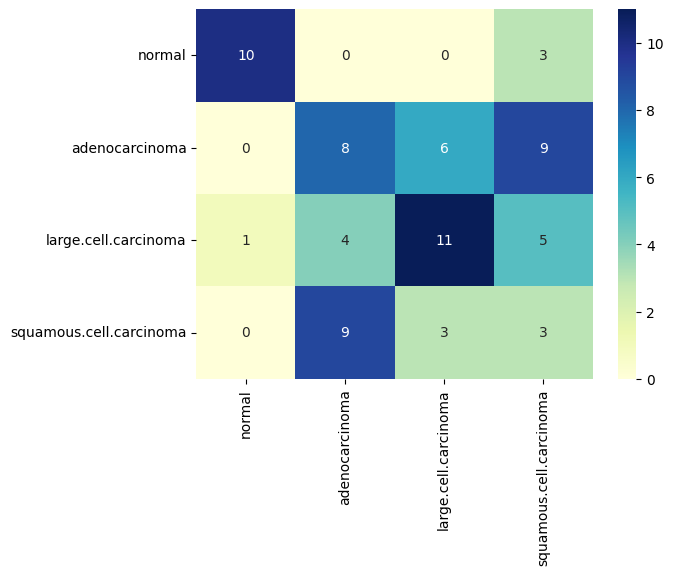

In [20]:
print("Decision Tree")
canny_preds = classify_decision_tree(X_train, train_labels, X_val, valid_labels)
plot_confusion_matrix(valid_labels, canny_preds)

SVM
Accuracy: 0.5972222222222222


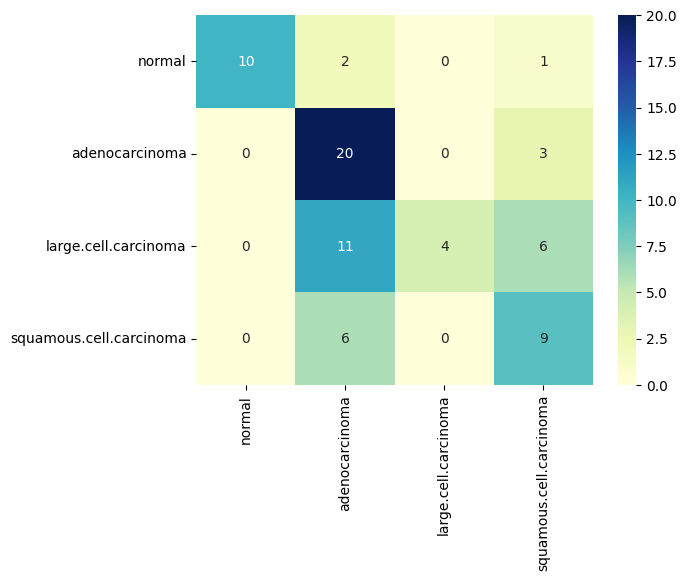

In [21]:
print("SVM")
canny_preds = linear_svm(X_train, train_labels, X_val, valid_labels)
plot_confusion_matrix(valid_labels, canny_preds)

RF
Accuracy: 0.5138888888888888


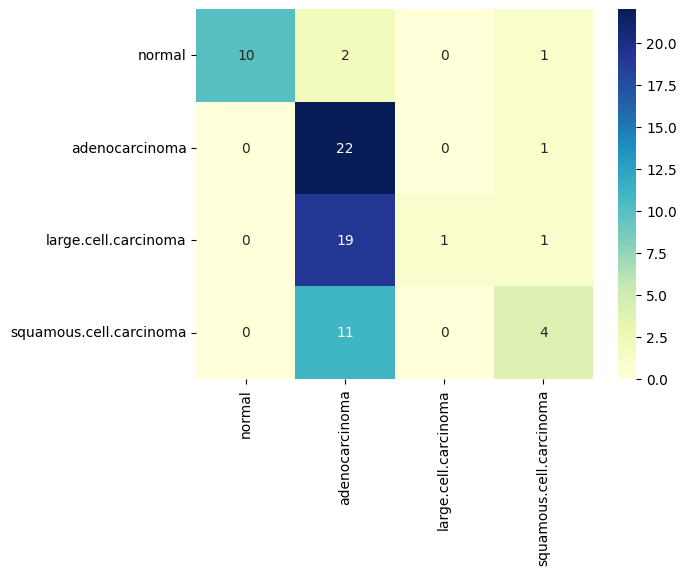

In [22]:
print("RF")
canny_preds = classify_rf(X_train, train_labels, X_val, valid_labels)
plot_confusion_matrix(valid_labels, canny_preds)

##### Hounsfield (Soft tissue filtered) image

In [23]:
X_train = np.array([img.flatten() for img in train_soft_tissue])
X_val = np.array([img.flatten() for img in valid_soft_tissue])

Decision Tree
Accuracy: 0.4861111111111111


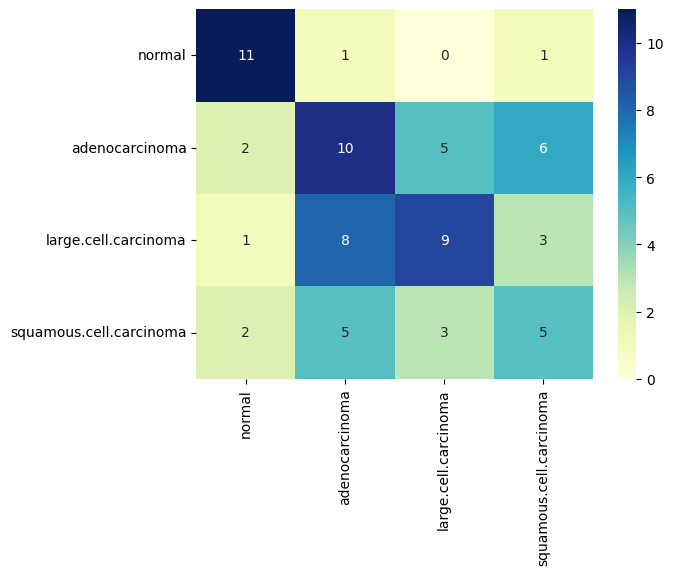

In [24]:
print("Decision Tree")
soft_tissue_preds = classify_decision_tree(X_train, train_labels, X_val, valid_labels)
plot_confusion_matrix(valid_labels, soft_tissue_preds)

SVM
Accuracy: 0.8055555555555556


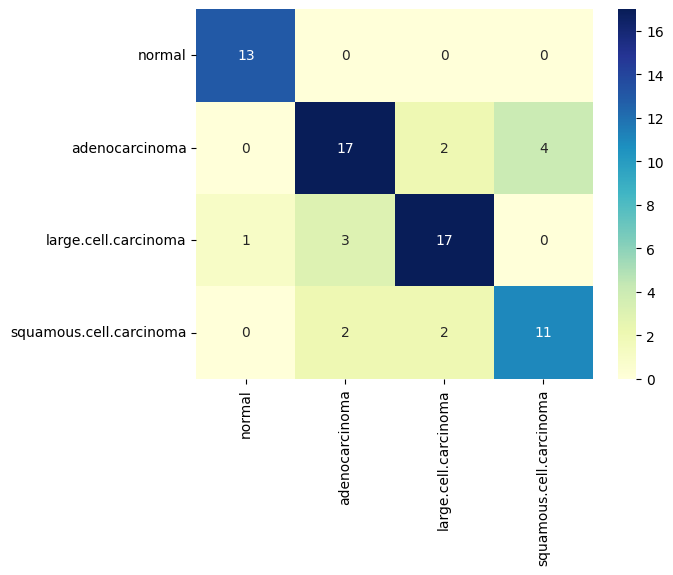

In [25]:
print("SVM")
soft_tissue_preds = linear_svm(X_train, train_labels, X_val, valid_labels)
plot_confusion_matrix(valid_labels, soft_tissue_preds)

RF
Accuracy: 0.6666666666666666


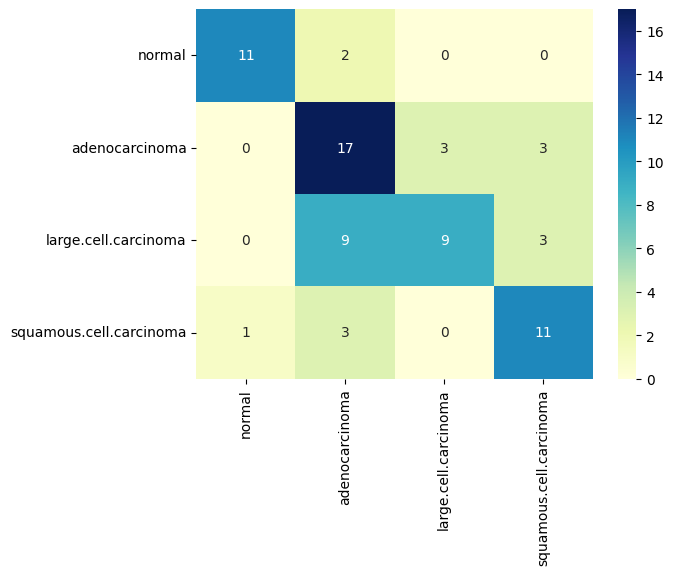

In [26]:
print("RF")
soft_tissue_preds = classify_rf(X_train, train_labels, X_val, valid_labels)
plot_confusion_matrix(valid_labels, soft_tissue_preds)

##### Resnet feature vector

In [27]:
# X_train = np.array([img.flatten() for img in train_resnet_feat])
# X_val = np.array([img.flatten() for img in valid_resnet_feat])

In [28]:
# print("Decision Tree")
# resnet_preds = classify_decision_tree(X_train, train_labels, X_val, valid_labels)
# plot_confusion_matrix(valid_labels, resnet_preds)

In [29]:
# print("SVM")
# resnet_preds = linear_svm(X_train, train_labels, X_val, valid_labels)
# plot_confusion_matrix(valid_labels, resnet_preds)

In [30]:
# print("RF")
# resnet_preds = classify_rf(X_train, train_labels, X_val, valid_labels)
# plot_confusion_matrix(valid_labels, resnet_preds)

##### Transformer feature vector

In [31]:
X_train = np.array([img.flatten() for img in train_transformer_feat])
X_val = np.array([img.flatten() for img in valid_transformer_feat])

Decision Tree
Accuracy: 0.5555555555555556


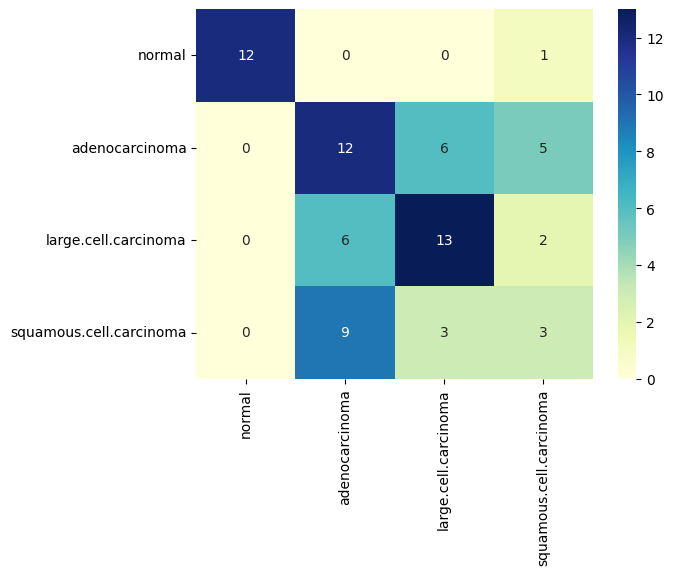

In [32]:
print("Decision Tree")
transformer_preds = classify_decision_tree(X_train, train_labels, X_val, valid_labels)
plot_confusion_matrix(valid_labels, transformer_preds)

SVM
Accuracy: 0.9027777777777778


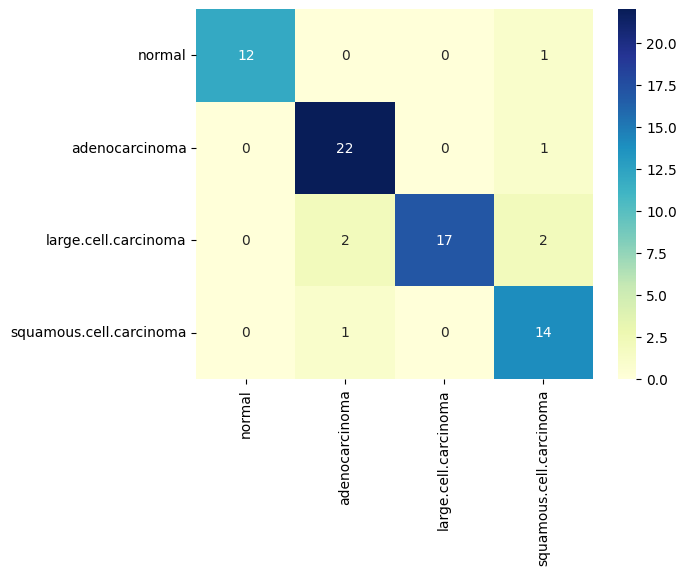

In [33]:
print("SVM")
transformer_preds = linear_svm(X_train, train_labels, X_val, valid_labels)
plot_confusion_matrix(valid_labels, transformer_preds)

RF
Accuracy: 0.7777777777777778


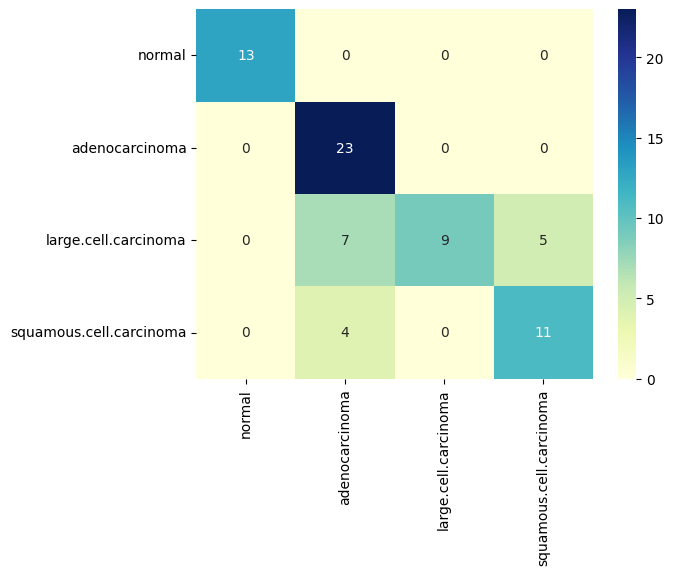

In [34]:
print("RF")
transformer_preds = classify_rf(X_train, train_labels, X_val, valid_labels)
plot_confusion_matrix(valid_labels, transformer_preds)

#### **Combined features**
This feature set yields better results than any of the individual edges alone

4 classes

In [35]:
X_train = [np.array([w, x, y, z]).flatten() for w, x, y, z in zip(train_sobel_edges, train_soft_tissue, train_threshold_edges, train_canny_edges)]
X_val = [np.array([w, x, y, z]).flatten() for w, x, y, z in zip(valid_sobel_edges, valid_soft_tissue, valid_threshold_edges, valid_canny_edges)]

Decision Tree
Accuracy: 0.4305555555555556


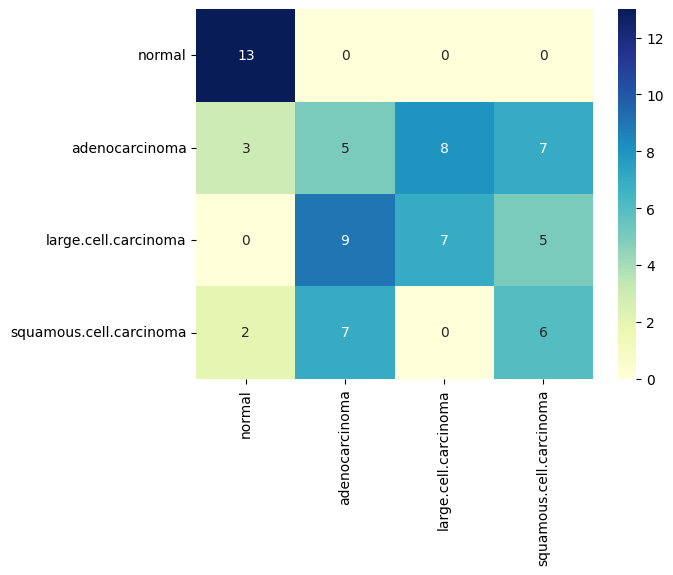

In [36]:
print("Decision Tree")
combined_preds = classify_decision_tree(X_train, train_labels, X_val, valid_labels)
plot_confusion_matrix(valid_labels, combined_preds)


SVM
Accuracy: 0.75


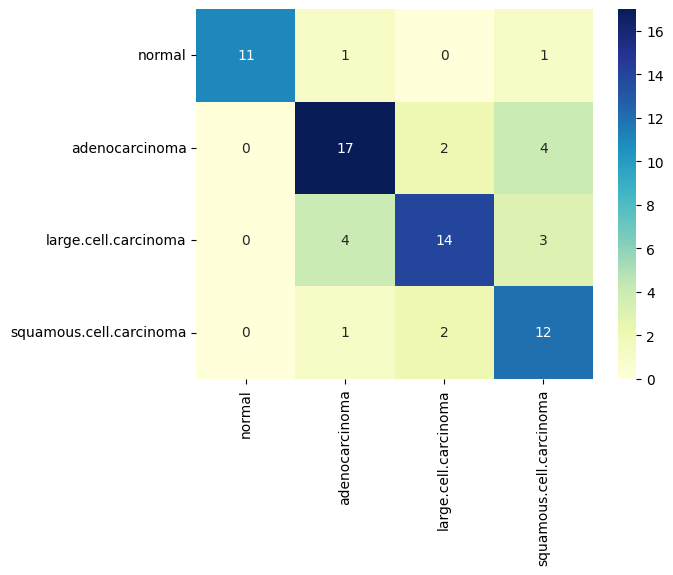

In [37]:
print("SVM")
combined_preds = linear_svm(X_train, train_labels, X_val, valid_labels)
plot_confusion_matrix(valid_labels, combined_preds)

2 classes

In [38]:
X_train = [np.array([w, x]).flatten() for w, x in zip(train_soft_tissue, train_canny_edges)]
X_val = [np.array([w, x]).flatten() for w, x in zip(valid_soft_tissue, valid_canny_edges)]

Decision Tree
Accuracy: 0.4722222222222222


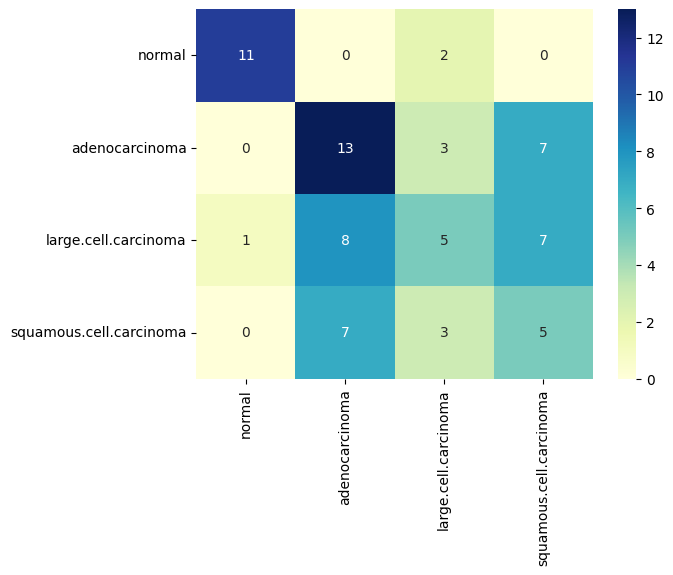

In [39]:
print("Decision Tree")
combined_preds = classify_decision_tree(X_train, train_labels, X_val, valid_labels)
plot_confusion_matrix(valid_labels, combined_preds)

SVM
Accuracy: 0.7638888888888888


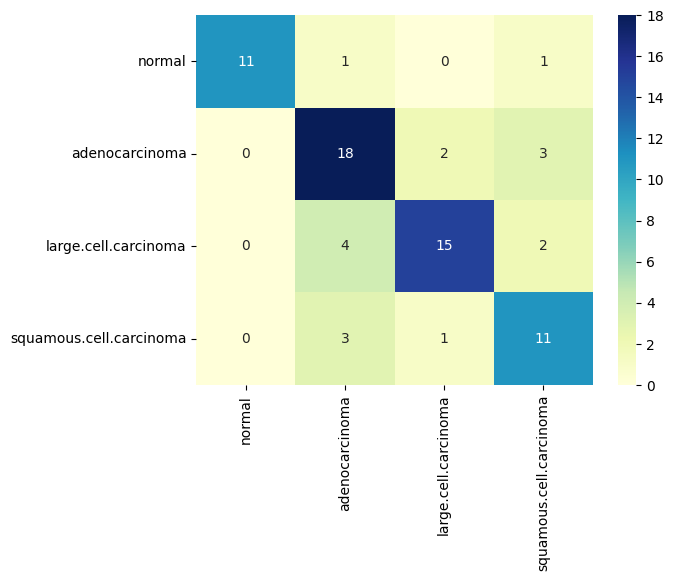

In [40]:
print("SVM")
combined_preds = linear_svm(X_train, train_labels, X_val, valid_labels)
plot_confusion_matrix(valid_labels, combined_preds)

Testing the PCA components

In [ ]:
print("Decision Tree")
combined_preds = classify_decision_tree(X_train_combined_pca, train_labels, X_val_combined_pca, valid_labels)

plot_confusion_matrix(valid_labels, combined_preds)

In [ ]:
print("SVM")
combined_preds = linear_svm(X_train, train_labels, X_val, valid_labels)
plot_confusion_matrix(valid_labels, combined_preds)

Testing the TSNE components

In [ ]:
print("Decision Tree")
combined_preds = classify_decision_tree(X_train_combined_tsne, train_labels, X_val_combined_tsne, valid_labels)
plot_confusion_matrix(valid_labels, combined_preds)

In [ ]:
print("SVM")
combined_preds = linear_svm(X_train, train_labels, X_val, valid_labels)
plot_confusion_matrix(valid_labels, combined_preds)